Experiment 1 with IAM dataset
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import time
import os
from utils import *
from classes import *

use_gpu = torch.cuda.is_available()

print('main imports complete')

main imports complete


In [2]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

net1_data_transforms = {
    'train': transforms.Compose([
#         transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor()
        
    ]),
    'val': transforms.Compose([
#         transforms.Resize(64),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    
    'test': transforms.Compose([
#         transforms.Resize(64),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [3]:
all_data_dir = '/home/rahul/data/handwriting/sampled/dim64x64-stride8x8/train_val_test-3'
set_types = ['train', 'val', 'test']

imagefolders = {t : datasets.ImageFolder(os.path.join(all_data_dir, t),
                                        transform = data_transforms[t])
               for t in set_types}
for t in set_types:
    print(str(t) + ' count:', len(imagefolders[t]))

train count: 7723
val count: 3478
test count: 2115


device_name cuda
Creating Net1.

Epoch 0/749
----------
Phase:train
average loss: 0.28229785109066396
f1_pos: 0.8843555437806332
f1_neg: 0.8894516905153855

Phase:val
average loss: 1.9717837105268992
f1_pos: 0.13232514177693763
f1_neg: 0.7435276587818961


Epoch 1/749
----------
Phase:train
average loss: 0.16934405189095794
f1_pos: 0.9357725717294025
f1_neg: 0.9378185524974515

Phase:val
average loss: 1.9334272423168926
f1_pos: 0.610521938032855
f1_neg: 0.12761993479273404


Epoch 2/749
----------
Phase:train
average loss: 0.16132095768501703
f1_pos: 0.9386624455876533
f1_neg: 0.9408773045136681

Phase:val
average loss: 1.0672147804255319
f1_pos: 0.6398952422522916
f1_neg: 0.30497051390058977


Epoch 3/749
----------
Phase:train
average loss: 0.15670058612809284
f1_pos: 0.9383172632413156
f1_neg: 0.9406984126984127

Phase:val
average loss: 2.992675869131719
f1_pos: 0.04258150365934797
f1_neg: 0.7361085640931597


Epoch 4/749
----------
Phase:train
average loss: 0.1490688517710929
f1_po

Phase:train
average loss: 0.10118388919521301
f1_pos: 0.9524818001323626
f1_neg: 0.9545051324293499

Phase:val
average loss: 0.5227702212717562
f1_pos: 0.8136882129277567
f1_neg: 0.8673394043809993


Epoch 38/749
----------
Phase:train
average loss: 0.10106387268160964
f1_pos: 0.9569707401032702
f1_neg: 0.9588242746737615

Phase:val
average loss: 0.4444642449124508
f1_pos: 0.7895125553914327
f1_neg: 0.865819209039548


Epoch 39/749
----------
Phase:train
average loss: 0.09388003507384238
f1_pos: 0.9577278731836195
f1_neg: 0.9593702386998477

Phase:val
average loss: 0.5480007934563458
f1_pos: 0.8458574181117534
f1_neg: 0.875065070275898


Epoch 40/749
----------
Phase:train
average loss: 0.09541953143943596
f1_pos: 0.9590055540862206
f1_neg: 0.9606798579401319

Phase:val
average loss: 1.4336792039350232
f1_pos: 0.8083102493074793
f1_neg: 0.7931858936043037


Epoch 41/749
----------
Phase:train
average loss: 0.09281356285793954
f1_pos: 0.9606008696797996
f1_neg: 0.9619447626320478

Phase

Phase:train
average loss: 0.0798111270690366
f1_pos: 0.9634226858576521
f1_neg: 0.9648164613235106

Phase:val
average loss: 0.6097721482159558
f1_pos: 0.8556348959950325
f1_neg: 0.8755020080321284


Epoch 75/749
----------
Phase:train
average loss: 0.07906971971605566
f1_pos: 0.9617269235862799
f1_neg: 0.9633945535148828

Phase:val
average loss: 0.5346708230207267
f1_pos: 0.8404433993953645
f1_neg: 0.8806232721789394


Epoch 76/749
----------
Phase:train
average loss: 0.0766851363912713
f1_pos: 0.9632469592808038
f1_neg: 0.9647297640192845

Phase:val
average loss: 0.7325532744848022
f1_pos: 0.7444794952681388
f1_neg: 0.8533936651583711


Epoch 77/749
----------
Phase:train
average loss: 0.08189219631573998
f1_pos: 0.9608701419286377
f1_neg: 0.9626912862020994

Phase:val
average loss: 1.77324320983448
f1_pos: 0.44351464435146454
f1_neg: 0.7890563045202221


Epoch 78/749
----------
Phase:train
average loss: 0.08083118881466367
f1_pos: 0.9642857142857144
f1_neg: 0.9657621100684758

Phase:

Phase:train
average loss: 0.0690405875889151
f1_pos: 0.9689064558629776
f1_neg: 0.9699592668024439

Phase:val
average loss: 2.893537109236802
f1_pos: 0.6304721030042918
f1_neg: 0.25


Epoch 112/749
----------
Phase:train
average loss: 0.07249133285773197
f1_pos: 0.964106624439166
f1_neg: 0.9654295882053888

Phase:val
average loss: 1.3608299563711166
f1_pos: 0.5825515947467167
f1_neg: 0.8155058043117744


Epoch 113/749
----------
Phase:train
average loss: 0.06535991537598737
f1_pos: 0.967154728927582
f1_neg: 0.9683407501589321

Phase:val
average loss: 4.282759280366552
f1_pos: 0.1643835616438356
f1_neg: 0.7491588785046729


Epoch 114/749
----------
Phase:train
average loss: 0.06341715766594275
f1_pos: 0.9685018528321863
f1_neg: 0.9698352344740178

Phase:val
average loss: 3.5357981875684494
f1_pos: 0.6275935828877005
f1_neg: 0.23673827268741782


Epoch 115/749
----------
Phase:train
average loss: 0.0711709806247224
f1_pos: 0.9637853555379328
f1_neg: 0.965228426395939

Phase:val
average l

Phase:train
average loss: 0.060402286770170746
f1_pos: 0.9720095062054397
f1_neg: 0.973069105691057

Phase:val
average loss: 0.6633489485133853
f1_pos: 0.8144440471934214
f1_neg: 0.8752103871122866


Epoch 149/749
----------
Phase:train
average loss: 0.05591849033716963
f1_pos: 0.9697933227344993
f1_neg: 0.9711319321347177

Phase:val
average loss: 1.7387147228768531
f1_pos: 0.5963133640552996
f1_neg: 0.8169661512745507


Epoch 150/749
----------
Phase:train
average loss: 0.05271695355185184
f1_pos: 0.9722515856236787
f1_neg: 0.9733434881949733

Phase:val
average loss: 0.6045416829536673
f1_pos: 0.8438448566610455
f1_neg: 0.883988975194187


Epoch 151/749
----------
Phase:train
average loss: 0.058094364813432844
f1_pos: 0.9695767195767196
f1_neg: 0.9708343900583313

Phase:val
average loss: 1.5418854722214403
f1_pos: 0.6419753086419754
f1_neg: 0.8267918088737202


Epoch 152/749
----------
Phase:train
average loss: 0.06157531643294306
f1_pos: 0.9683987835515007
f1_neg: 0.9696815933020424


Phase:train
average loss: 0.057655453558777395
f1_pos: 0.9702420314773178
f1_neg: 0.9714648065948002

Phase:val
average loss: 0.803064106969466
f1_pos: 0.8584474885844748
f1_neg: 0.8733315172977391


Epoch 186/749
----------
Phase:train
average loss: 0.04942445927719818
f1_pos: 0.9708532061473237
f1_neg: 0.9721448467966574

Phase:val
average loss: 1.2893825437640103
f1_pos: 0.6848832084618776
f1_neg: 0.8474503947087689


Epoch 187/749
----------
Phase:train
average loss: 0.05586573279642556
f1_pos: 0.9705143461589316
f1_neg: 0.9717112774324497

Phase:val
average loss: 0.7084567382666076
f1_pos: 0.8135072908672295
f1_neg: 0.8882758620689656


Epoch 188/749
----------
Phase:train
average loss: 0.055736612030281456
f1_pos: 0.969969572694801
f1_neg: 0.9712184607582097

Phase:val
average loss: 0.7556688073484839
f1_pos: 0.8563011456628478
f1_neg: 0.8874647526275314


Epoch 189/749
----------
Phase:train
average loss: 0.05401429113482512
f1_pos: 0.968642040924794
f1_neg: 0.9702020202020203



Phase:train
average loss: 0.047639324828436316
f1_pos: 0.972729679639926
f1_neg: 0.9738976178408515

Phase:val
average loss: 0.8239821687794884
f1_pos: 0.8525557011795544
f1_neg: 0.884733606557377


Epoch 223/749
----------
Phase:train
average loss: 0.05591781586447204
f1_pos: 0.9694404021695991
f1_neg: 0.9707112970711297

Phase:val
average loss: 4.075507234471361
f1_pos: 0.6292955326460481
f1_neg: 0.24956521739130436


Epoch 224/749
----------
Phase:train
average loss: 0.053008100620979715
f1_pos: 0.9680752417538746
f1_neg: 0.9694820818032164

Phase:val
average loss: 0.6160844501714174
f1_pos: 0.8373777616805504
f1_neg: 0.8929678188319429


Epoch 225/749
----------
Phase:train
average loss: 0.050625746298176656
f1_pos: 0.968820485604352
f1_neg: 0.9702870147932735

Phase:val
average loss: 1.2649640919080474
f1_pos: 0.7559183673469387
f1_neg: 0.8672880603639591


Epoch 226/749
----------
Phase:train
average loss: 0.050686707972677575
f1_pos: 0.9730230097857708
f1_neg: 0.974124809741248


Phase:val
average loss: 1.159323160061554
f1_pos: 0.6774269005847954
f1_neg: 0.4856396866840731


Epoch 259/749
----------
Phase:train
average loss: 0.04310014448776816
f1_pos: 0.9748120796518529
f1_neg: 0.9757090169146637

Phase:val
average loss: 5.494693493966469
f1_pos: 0.6290495601802188
f1_neg: 0.2466230936819172


Epoch 260/749
----------
Phase:train
average loss: 0.046827194283213636
f1_pos: 0.9740946338884482
f1_neg: 0.9751269035532996

Phase:val
average loss: 0.518833080727592
f1_pos: 0.8757555406312961
f1_neg: 0.9069884364002012


Epoch 261/749
----------
Phase:train
average loss: 0.04821724757319648
f1_pos: 0.9747521480502312
f1_neg: 0.9757644968912574

Phase:val
average loss: 2.2525901128122903
f1_pos: 0.6007568590350046
f1_neg: 0.825691862866584


Epoch 262/749
----------
Phase:train
average loss: 0.04950860002870759
f1_pos: 0.9715194065439131
f1_neg: 0.9727744713182221

Phase:val
average loss: 0.8079686819513068
f1_pos: 0.8141459744168549
f1_neg: 0.8850628199162401


Epoc

Phase:train
average loss: 0.04226165131616203
f1_pos: 0.9758160433461082
f1_neg: 0.976773702246478

Phase:val
average loss: 0.9165596405002425
f1_pos: 0.814226258040106
f1_neg: 0.886158126594018


Epoch 296/749
----------
Phase:train
average loss: 0.044657974565857746
f1_pos: 0.9759195554379466
f1_neg: 0.9769269776876268

Phase:val
average loss: 0.5738584861253582
f1_pos: 0.8601997146932953
f1_neg: 0.9055876685934489


Epoch 297/749
----------
Phase:train
average loss: 0.052981678398392844
f1_pos: 0.9726516052318668
f1_neg: 0.9737209597562524

Phase:val
average loss: 3.351495666432614
f1_pos: 0.6324638930804053
f1_neg: 0.2641346568839016


Epoch 298/749
----------
Phase:train
average loss: 0.04148151283324243
f1_pos: 0.9755323369924613
f1_neg: 0.9765377298668357

Phase:val
average loss: 0.7128820812105789
f1_pos: 0.8379717880289745
f1_neg: 0.9019155319639972


Epoch 299/749
----------
Phase:train
average loss: 0.043409925101934276
f1_pos: 0.9724430312665606
f1_neg: 0.973664218789567

P

Phase:val
average loss: 1.552702287273067
f1_pos: 0.7231298366294068
f1_neg: 0.8609071274298056


Epoch 332/749
----------
Phase:train
average loss: 0.04129062876531356
f1_pos: 0.9751322751322751
f1_neg: 0.9761602840476795

Phase:val
average loss: 0.479867603910456
f1_pos: 0.8959390862944162
f1_neg: 0.9137749737118822


Epoch 333/749
----------
Phase:train
average loss: 0.04309446575771523
f1_pos: 0.9760993001452529
f1_neg: 0.977010034294424

Phase:val
average loss: 1.5309685568071907
f1_pos: 0.7079490557751428
f1_neg: 0.8578756144475316


Epoch 334/749
----------
Phase:train
average loss: 0.049505165425915126
f1_pos: 0.9744742758894326
f1_neg: 0.9755231452124287

Phase:val
average loss: 0.4829685585193075
f1_pos: 0.8738216098622189
f1_neg: 0.9171033825631253


Epoch 335/749
----------
Phase:train
average loss: 0.04068152870532841
f1_pos: 0.9755452742894912
f1_neg: 0.9765258215962442

Phase:val
average loss: 0.4948503833313383
f1_pos: 0.9036375239310785
f1_neg: 0.9209837781266352


Epo

Phase:train
average loss: 0.04026197637255261
f1_pos: 0.977536997885835
f1_neg: 0.9784209190149784

Phase:val
average loss: 0.2932317748777204
f1_pos: 0.9262068965517241
f1_neg: 0.9472386587771203


Epoch 369/749
----------
Phase:train
average loss: 0.04054351586748829
f1_pos: 0.9767380385937088
f1_neg: 0.9776649746192893

Phase:val
average loss: 0.43590361659659815
f1_pos: 0.8916453848960233
f1_neg: 0.9295373665480425


Epoch 370/749
----------
Phase:train
average loss: 0.03924696512253084
f1_pos: 0.9756484912652198
f1_neg: 0.9766793409378962

Phase:val
average loss: 0.3997061423284696
f1_pos: 0.9140032948929159
f1_neg: 0.9334353481254783


Epoch 371/749
----------
Phase:train
average loss: 0.03953393601111669
f1_pos: 0.9741276369908451
f1_neg: 0.975344544190163

Phase:val
average loss: 0.3811009028319177
f1_pos: 0.9053638537751965
f1_neg: 0.9312484487465872


Epoch 372/749
----------
Phase:train
average loss: 0.041222991203187655
f1_pos: 0.9784761653241779
f1_neg: 0.9792963292264703


Phase:val
average loss: 0.762087625117738
f1_pos: 0.872655478775913
f1_neg: 0.9011998978810315


Epoch 405/749
----------
Phase:train
average loss: 0.035508644092158995
f1_pos: 0.9765780071456927
f1_neg: 0.9775636962859678

Phase:val
average loss: 1.8515400817985161
f1_pos: 0.7450980392156864
f1_neg: 0.8702819956616052


Epoch 406/749
----------
Phase:train
average loss: 0.03714920410091834
f1_pos: 0.9775251189846642
f1_neg: 0.9784318700837351

Phase:val
average loss: 0.39520888132497867
f1_pos: 0.9126406353408338
f1_neg: 0.932892730045755


Epoch 407/749
----------
Phase:train
average loss: 0.035683893676155994
f1_pos: 0.9784704794611015
f1_neg: 0.9793015873015873

Phase:val
average loss: 0.6412982423974564
f1_pos: 0.8738317757009345
f1_neg: 0.9045454545454545


Epoch 408/749
----------
Phase:train
average loss: 0.046784604143360484
f1_pos: 0.9718981972428419
f1_neg: 0.9731713490255631

Phase:val
average loss: 0.8957940235159876
f1_pos: 0.8698278465720326
f1_neg: 0.881755829903978


E

Phase:train
average loss: 0.03448826611984379
f1_pos: 0.9769719428268926
f1_neg: 0.9779467680608366

Phase:val
average loss: 0.4714827055455351
f1_pos: 0.9021815622800845
f1_neg: 0.9324258629071464


Epoch 442/749
----------
Phase:train
average loss: 0.04379889752537834
f1_pos: 0.9740877842411422
f1_neg: 0.9751332149200712

Phase:val
average loss: 0.9302811600340722
f1_pos: 0.8390243902439024
f1_neg: 0.9000233045910043


Epoch 443/749
----------
Phase:train
average loss: 0.04375685248318343
f1_pos: 0.9740534815991526
f1_neg: 0.9751647237709073

Phase:val
average loss: 16.407892947775526
f1_pos: 0.6050247116968699
f1_neg: 0.08666666666666667


Epoch 444/749
----------
Phase:train
average loss: 0.04343822851872826
f1_pos: 0.9747721569145422
f1_neg: 0.9757460317460318

Phase:val
average loss: 1.2476938855312143
f1_pos: 0.8481308411214954
f1_neg: 0.8527746319365799


Epoch 445/749
----------
Phase:train
average loss: 0.0393692453197518
f1_pos: 0.9744336998277917
f1_neg: 0.9755603393693808


Phase:val
average loss: 1.2771134855008248
f1_pos: 0.7878048780487804
f1_neg: 0.8838967971530248


Epoch 478/749
----------
Phase:train
average loss: 0.03869626268200122
f1_pos: 0.9765965886552955
f1_neg: 0.9775466193073703

Phase:val
average loss: 2.4467626759346497
f1_pos: 0.6848457755923112
f1_neg: 0.8506039415130324


Epoch 479/749
----------
Phase:train
average loss: 0.04597631366119111
f1_pos: 0.9739107402992981
f1_neg: 0.9750474984167194

Phase:val
average loss: 6.98853217218716
f1_pos: 0.7549498585754693
f1_neg: 0.6892729051190087


Epoch 480/749
----------
Phase:train
average loss: 0.0403309508400342
f1_pos: 0.9778539414711309
f1_neg: 0.9786259541984733

Phase:val
average loss: 0.3787275149704928
f1_pos: 0.9163458172908645
f1_neg: 0.9416930958770432


Epoch 481/749
----------
Phase:train
average loss: 0.037277405390572116
f1_pos: 0.976023314346271
f1_neg: 0.9770799037609218

Phase:val
average loss: 0.8965122892364406
f1_pos: 0.8489320388349514
f1_neg: 0.9112074868751426


Epoc

Phase:train
average loss: 0.04116937952970156
f1_pos: 0.9751454257006875
f1_neg: 0.97614818573966

Phase:val
average loss: 0.3537590172251043
f1_pos: 0.922272568839317
f1_neg: 0.9454367506728653


Epoch 515/749
----------
Phase:train
average loss: 0.038317459693907985
f1_pos: 0.9767318878900052
f1_neg: 0.9776706419690434

Phase:val
average loss: 2.1973594664293437
f1_pos: 0.6953436807095343
f1_neg: 0.8538608806636886


Epoch 516/749
----------
Phase:train
average loss: 0.0377187896125869
f1_pos: 0.9740053050397878
f1_neg: 0.9752087022514545

Phase:val
average loss: 0.37842612838251555
f1_pos: 0.9166077738515902
f1_neg: 0.9428017450315076


Epoch 517/749
----------
Phase:train
average loss: 0.036522707045037274
f1_pos: 0.9771496499801877
f1_neg: 0.9780317460317459

Phase:val
average loss: 0.5243251193539722
f1_pos: 0.895778364116095
f1_neg: 0.9194699286442406


Epoch 518/749
----------
Phase:train
average loss: 0.03649280471304732
f1_pos: 0.9762945305257582
f1_neg: 0.9773274224192527

P

Phase:val
average loss: 0.9642625837369923
f1_pos: 0.8454011741682974
f1_neg: 0.9102476709838672


Epoch 551/749
----------
Phase:train
average loss: 0.03601150043602012
f1_pos: 0.9752153744201457
f1_neg: 0.9763321098595115

Phase:val
average loss: 0.5569519186976176
f1_pos: 0.8962516733601071
f1_neg: 0.9218750000000001


Epoch 552/749
----------
Phase:train
average loss: 0.0455129232022332
f1_pos: 0.9709895350377533
f1_neg: 0.9722679498543751

Phase:val
average loss: 0.6125865133587419
f1_pos: 0.8762117822520509
f1_neg: 0.9223210107627514


Epoch 553/749
----------
Phase:train
average loss: 0.037541265339797666
f1_pos: 0.9763446544205101
f1_neg: 0.9772813808858992

Phase:val
average loss: 0.495812945474901
f1_pos: 0.9095337508698678
f1_neg: 0.9363057324840764


Epoch 554/749
----------
Phase:train
average loss: 0.0356272116098922
f1_pos: 0.9759004237288136
f1_neg: 0.9769445148213834

Phase:val
average loss: 0.35538739673771896
f1_pos: 0.9263525305410122
f1_neg: 0.9484233683695917


Ep

Phase:train
average loss: 0.04206120714277659
f1_pos: 0.9764612536366041
f1_neg: 0.9774226281075595

Phase:val
average loss: 0.3896311809356491
f1_pos: 0.9179434797412325
f1_neg: 0.9400348345359542


Epoch 588/749
----------
Phase:train
average loss: 0.0453762096947026
f1_pos: 0.9741482168898316
f1_neg: 0.9753258256358345

Phase:val
average loss: 0.3447959592599098
f1_pos: 0.9244819107832807
f1_neg: 0.9476758335361403


Epoch 589/749
----------
Phase:train
average loss: 0.03788532725463341
f1_pos: 0.9773659827928524
f1_neg: 0.9783297427448993

Phase:val
average loss: 0.3670433608706893
f1_pos: 0.9219613259668509
f1_neg: 0.9443349753694582


Epoch 590/749
----------
Phase:train
average loss: 0.03530749938834594
f1_pos: 0.9767010855176066
f1_neg: 0.9776989356310187

Phase:val
average loss: 0.42022707543371735
f1_pos: 0.9102340202584701
f1_neg: 0.937209870510628


Epoch 591/749
----------
Phase:train
average loss: 0.0322191631210413
f1_pos: 0.9775132275132273
f1_neg: 0.9784428100431144

P

Phase:train
average loss: 0.03564653985484977
f1_pos: 0.9773899246330822
f1_neg: 0.978307750856273

Phase:val
average loss: 0.954438581214409
f1_pos: 0.867175572519084
f1_neg: 0.9197416974169742


Epoch 625/749
----------
Phase:train
average loss: 0.03482796602427697
f1_pos: 0.9782005548949664
f1_neg: 0.9790529389361433

Phase:val
average loss: 0.9451875958790924
f1_pos: 0.6941262490860346
f1_neg: 0.560112162635822


Epoch 626/749
----------
Phase:train
average loss: 0.044807366208718044
f1_pos: 0.9766151407055094
f1_neg: 0.9775295163133173

Phase:val
average loss: 0.8399561816176304
f1_pos: 0.8741923223109085
f1_neg: 0.9234682080924855


Epoch 627/749
----------
Phase:train
average loss: 0.031841239251767565
f1_pos: 0.978318350079323
f1_neg: 0.9791930981984268

Phase:val
average loss: 0.3140447459313772
f1_pos: 0.9315068493150686
f1_neg: 0.9504459861248761


Epoch 628/749
----------
Phase:train
average loss: 0.03302628087580723
f1_pos: 0.977942147668736
f1_neg: 0.9787936507936509

Pha

Phase:val
average loss: 0.3442756180330691
f1_pos: 0.9297259311314124
f1_neg: 0.951338199513382


Epoch 661/749
----------
Phase:train
average loss: 0.0367936228014742
f1_pos: 0.9765842042598227
f1_neg: 0.9775580068467098

Phase:val
average loss: 1.2220677016040524
f1_pos: 0.6875
f1_neg: 0.5850066934404284


Epoch 662/749
----------
Phase:train
average loss: 0.03628741346095126
f1_pos: 0.9773087071240105
f1_neg: 0.97813374014747

Phase:val
average loss: 0.6200877254365024
f1_pos: 0.8898708361658736
f1_neg: 0.9192825112107623


Epoch 663/749
----------
Phase:train
average loss: 0.038460450455109374
f1_pos: 0.9765965886552955
f1_neg: 0.9775466193073703

Phase:val
average loss: 0.6465824136554407
f1_pos: 0.8790596968759667
f1_neg: 0.8949771689497716


Epoch 664/749
----------
Phase:train
average loss: 0.0362719035693305
f1_pos: 0.9763070814030443
f1_neg: 0.9773159295399823

Phase:val
average loss: 0.6331849070485465
f1_pos: 0.8933631618195378
f1_neg: 0.9330837622835751


Epoch 665/749
---

Phase:train
average loss: 0.03639051332060698
f1_pos: 0.9791501715492213
f1_neg: 0.9799186578546009

Phase:val
average loss: 0.7347544902285466
f1_pos: 0.8834921610820781
f1_neg: 0.8976505536051849


Epoch 698/749
----------
Phase:train
average loss: 0.03375807778245528
f1_pos: 0.9783298097251586
f1_neg: 0.9791825336379792

Phase:val
average loss: 0.3538480441441064
f1_pos: 0.9308437067773166
f1_neg: 0.9507874015748031


Epoch 699/749
----------
Phase:train
average loss: 0.03347719241446529
f1_pos: 0.9779246530072704
f1_neg: 0.9788097957112042

Phase:val
average loss: 0.42171356007413935
f1_pos: 0.9163179916317993
f1_neg: 0.9412915851272016


Epoch 700/749
----------
Phase:train
average loss: 0.03797549024722562
f1_pos: 0.9765047518479408
f1_neg: 0.9773824650571792

Phase:val
average loss: 0.6937643091455145
f1_pos: 0.8900787401574803
f1_neg: 0.9076963766199418


Epoch 701/749
----------
Phase:train
average loss: 0.035769972357425996
f1_pos: 0.975364238410596
f1_neg: 0.9764437689969604

Phase:train
average loss: 0.02945486842545586
f1_pos: 0.978729026291452
f1_neg: 0.9795607464770852

Phase:val
average loss: 1.7631451032708745
f1_pos: 0.7927927927927928
f1_neg: 0.8879042977403633


Epoch 735/749
----------
Phase:train
average loss: 0.03737119710809519
f1_pos: 0.9758288204992734
f1_neg: 0.9767619047619047

Phase:val
average loss: 0.6376276774060938
f1_pos: 0.8920712539294446
f1_neg: 0.9245052528707549


Epoch 736/749
----------
Phase:train
average loss: 0.03802270477894024
f1_pos: 0.9772727272727273
f1_neg: 0.9781670474739782

Phase:val
average loss: 0.4852006417399785
f1_pos: 0.9142244460328807
f1_neg: 0.9422799422799423


Epoch 737/749
----------
Phase:train
average loss: 0.03538056849858373
f1_pos: 0.9784704794611015
f1_neg: 0.9793015873015873

Phase:val
average loss: 0.6822534946616591
f1_pos: 0.8896396396396397
f1_neg: 0.9315004659832247


Epoch 738/749
----------
Phase:train
average loss: 0.03370101189318715
f1_pos: 0.9806043013590184
f1_neg: 0.9813143510868183



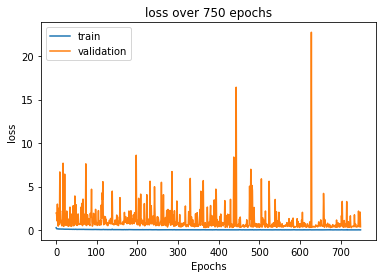

Average Training Score: 0.051143437890992884
Average Validation Score: 1.1074250390665314


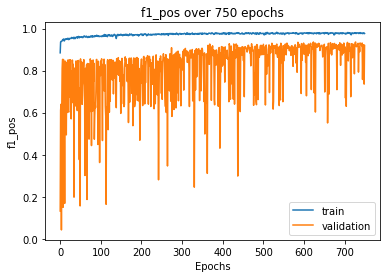

Average Training Score: 0.9722990283160093
Average Validation Score: 0.812821338832385


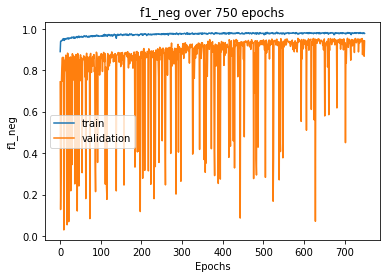

Average Training Score: 0.9734259317082252
Average Validation Score: 0.8373378604509762



In [4]:
from model_utils import create_model_architecture
from train_utils import train

use_gpu = True
device_name = 'cuda' if use_gpu else 'cpu'
print('device_name', device_name)

batch_size = 100

phases = ['train', 'val']
metric_types = ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']
metric_types_plot = ['loss', 'f1_pos', 'f1_neg']
metric_names_all = [p+'-'+m for p in phases for m in metric_types]
metric_names_plot = [p+'-'+m for p in phases for m in metric_types_plot]

all_metrics = {metric : [] for metric in metric_names_all}

num_training_epochs = 750

data_loaders = {t : torch.utils.data.DataLoader(imagefolders[t], batch_size = batch_size, shuffle = True, num_workers = 4)
                for t in phases}

model = create_model_architecture('net1', use_gpu = use_gpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model, train_metrics = train(model,
                                     criterion,
                                     optimizer,
                                     data_loaders['train'],
                                     data_loaders['val'],
                                     num_epochs=num_training_epochs,
                                     use_gpu = use_gpu)

all_metrics = train_metrics

for metric in metric_types_plot:
    plot_values(all_metrics['train-' + str(metric)],
               all_metrics['val-' + str(metric)],
               str(metric) + " over " + str(num_training_epochs) + " epochs",
               ylabel = str(metric))

# write metrics to file
# write_metrics_to_csv(all_metrics, metric_names_all, 'net1-IAM-aa_64-raw_logs', 'all_metrics.csv')

print()


In [5]:
# write metrics to file
write_metrics_to_csv(all_metrics, metric_names_all, 'net1-aa_64-750ep-raw_logs', 'all_metrics.csv')
torch.save(trained_model.state_dict(), 'models/net1-aa_64-750ep.pt')

Wrote metrics to 'net1-aa_64-750ep-raw_logs/all_metrics.csv'


In [6]:

# import sys
# import os
# sys.path.append(os.path.abspath('../../../'))
# from detection.lib.model.ImageROI import ImageROI
# from PIL import Image

# # book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
# # img_loc = book_data_dir + '/Dryden/positive/307.png'
# # Testing with image of dimensions 1000x1381

# img_loc = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images/Allestree/positive/1307.png'
# pilimg = Image.open(img_loc)
# w, h = pilimg.size
# imgrois = [ImageROI(0, 0, w, h)]
# imgarr = np.asarray(pilimg)

# from bounding_box_classification import get_pos_rois
# # net1 = Net1()

# # Modify this as necessary
# # imgrois = [ImageROI(0, 0, 1000, 700), ImageROI(0, 750, 1000, 500)]
# trained_model.train(False)
# with torch.set_grad_enabled(False):
#     pos_rois = get_pos_rois(trained_model,
#                             (pilimg, imgrois),
#                             model_transform = net1_data_transforms['test'],
#                             model_input_size = (64,64),
#                             stride=(32, 32))

# for rois in pos_rois:
#     for roi in rois:
#         print(roi.toString())
        
# all_rois = [roi for rois in pos_rois for roi in rois]
    
# print('number of pos ROIs found', len(all_rois))

# from detection.lib.ImgProcessor import ImgProcessor
# from detection.lib.utils.Utils import plt_img
# # plot the rois and plot only certain information according to the set
# # imgProcessor = ImgProcessor()
# # img = imgProcessor.loadImage(inFilename=img_loc)
# roi_level_set = set([1])
# plt_img(imgarr, rois=all_rois, roi_level_set=roi_level_set)

In [7]:

# import sys
# import os.path
# sys.path.append(os.path.abspath('../../../'))


# # from detection.lib.ImgProcessor import ImgProcessor
# import matplotlib.pyplot as plt
# import numpy as np
# from detection.lib.utils.Utils import *
# from detection.lib.OCREngine import OCREngine
# import pickle

# from PIL import Image

# # 1. parameters
# # root_dir = './sample'
# # img_id = '639'
# # fname = '%s.png' %img_id
# # ocr_engine = 'cv2'
# # f = '%s/%s' % (root_dir,fname)

# ocr_engine = 'tesseract'
# img_id = '1307'
# fname = '1307.png'
# f = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images/Allestree/positive/1307.png'

# # 2. Load the image
# # imgProcessor = ImgProcessor()
# # img = imgProcessor.loadImage(inFilename=f)
# img = np.asarray(Image.open(f))

# # 3. preprocess the image
# # img = imgProcessor.quickPreprocess(img)

# # 4. load the image ground truth
# # img_roi_ground_truth = all_ground_truth[img_id]

# # 5. define the OCR
# # define engine
# ocr = OCREngine(ocr_engine)
# img_roi_ocr, data_df = ocr.image_to_data(img)

# # plot the rois and plot only certain information according to the set
# # roi_level_set = set([2])
# # rois = [(img_roi_ground_truth,'b'), (img_roi_ocr,'r')]
# rois = [(img_roi_ocr,'r')]
# plt_img(img, rois=rois)#, roi_level_set=roi_level_set)

# # save the plot
# plt.savefig('./result/%s_%s_boxes.png' %(fname,ocr_engine))

# # save the bounding boxes to txt
# # save_rois(img_roi_ground_truth,'./result/%s_imgROIs_ground_truth.txt' %fname)
# save_rois(img_roi_ocr,'./result/%s_imgROIs.txt' %fname)

# # save the bounding boxes to pickle
# # with open('./result/%s_imgROIs.pkl' %fname,'wb') as f:
# #     pickle.dump({'ocr':img_roi_ocr, 'ground_truth':img_roi_ground_truth},f)

